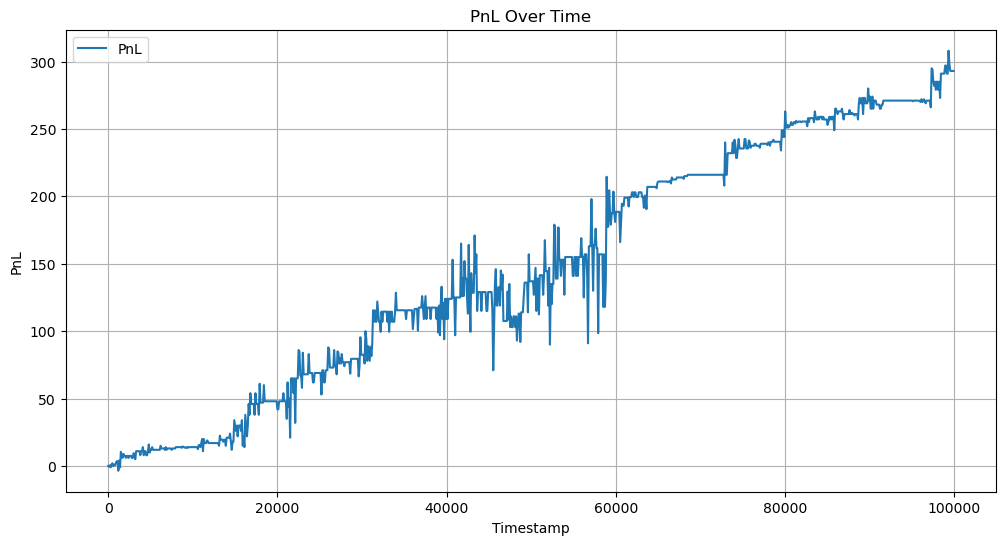

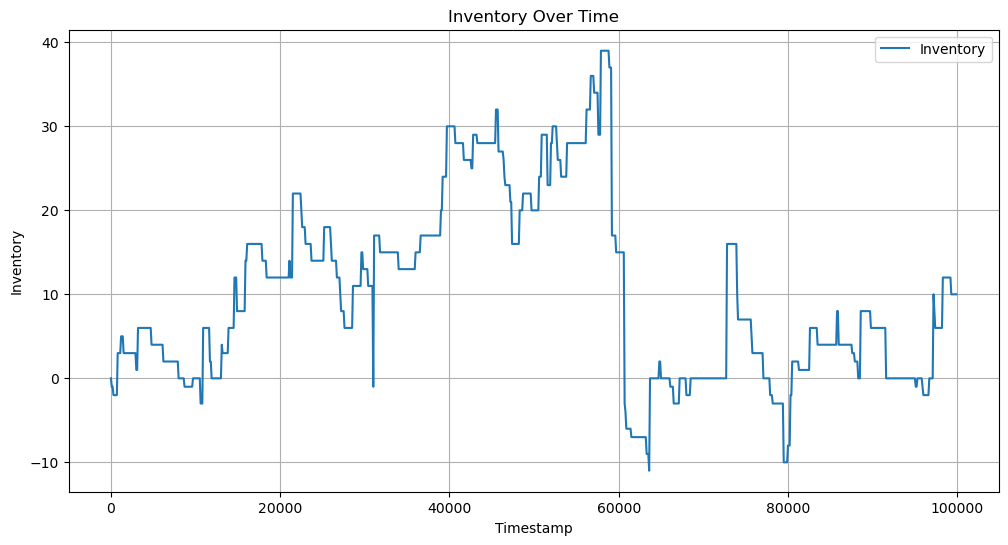

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datamodel import OrderDepth, Order, TradingState
from tryout_KELP import Trader, Product  # <-- Change 'your_trader_file' to the name of your trader file

# 1. Load Data
df = pd.read_csv('Dati.csv', sep=';')

# 2. Initialize Trader
trader = Trader()

# 3. Initialize Tracking Variables
position = {Product.KELP: 0}
cash = 0
pnl_history = []
inventory_history = []
timestamps = []

# 4. Run Backtest
for idx, row in df[df['product'] == 'KELP'].iterrows():  # Only trading KELP

    # Build the OrderBook (OrderDepth)
    order_depth = OrderDepth()

    # Add buy orders (bids)
    if not np.isnan(row['bid_price_1']):
        order_depth.buy_orders[row['bid_price_1']] = row['bid_volume_1']
    if not np.isnan(row['bid_price_2']):
        order_depth.buy_orders[row['bid_price_2']] = row['bid_volume_2']
    if not np.isnan(row['bid_price_3']):
        order_depth.buy_orders[row['bid_price_3']] = row['bid_volume_3']

    # Add sell orders (asks)
    if not np.isnan(row['ask_price_1']):
        order_depth.sell_orders[row['ask_price_1']] = -row['ask_volume_1']
    if not np.isnan(row['ask_price_2']):
        order_depth.sell_orders[row['ask_price_2']] = -row['ask_volume_2']
    if not np.isnan(row['ask_price_3']):
        order_depth.sell_orders[row['ask_price_3']] = -row['ask_volume_3']

    # Build the TradingState
    state = TradingState(
        traderData="",
        timestamp=row['timestamp'],
        listings={},
        order_depths={Product.KELP: order_depth},
        own_trades={},
        market_trades={},
        position=position,
        observations={},
    )

    # Get the Trader's Orders
    orders, conversions, traderData = trader.run(state)

    # 5. Execute Orders
    for order in orders.get(Product.KELP, []):
        if order.quantity > 0:
            # BUY order: Cross with current sell side (ask)
            best_ask = min(order_depth.sell_orders.keys())
            if order.price >= best_ask:  # Aggressive enough
                quantity_filled = min(order.quantity, -order_depth.sell_orders[best_ask])
                execution_price = best_ask
                position[Product.KELP] += quantity_filled
                cash -= execution_price * quantity_filled
        elif order.quantity < 0:
            # SELL order: Cross with current buy side (bid)
            best_bid = max(order_depth.buy_orders.keys())
            if order.price <= best_bid:  # Aggressive enough
                quantity_filled = min(-order.quantity, order_depth.buy_orders[best_bid])
                execution_price = best_bid
                position[Product.KELP] -= quantity_filled
                cash += execution_price * quantity_filled

    # 6. Mark-to-Market PnL
    mid_price = row['mid_price']
    current_pnl = cash + position[Product.KELP] * mid_price
    pnl_history.append(current_pnl)
    inventory_history.append(position[Product.KELP])
    timestamps.append(row['timestamp'])

# 7. Plot Results
plt.figure(figsize=(12, 6))
plt.plot(timestamps, pnl_history, label='PnL')
plt.title('PnL Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, inventory_history, label='Inventory')
plt.title('Inventory Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()